In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'rlops',
    'password': 'jTeL85L!',
    'options': f'-c search_path=rl',
}

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [10]:
# Load the game buffer
with psycopg2.connect(**dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
df.tail(20)

,id,time,experiment_id,gameid,real_reward,final_smiles
1370,3010,2020-10-20 14:16:08.218529,0003_noh,6a298f74,82.267780,CC1=[C]C(=O)NC(=O)CC1
1371,3011,2020-10-20 14:16:08.767908,0003_noh,39529324,77.014320,CN1CCC=[C]C(=O)C1
1372,3012,2020-10-20 14:16:10.430620,0003_noh,3a256f77,72.851540,CC1=[C]C(=O)C(=O)N1C
1373,3013,2020-10-20 14:16:10.647321,0003_noh,e54f6c29,66.912130,O=[C]C(=O)N1CC1
1374,3014,2020-10-20 14:16:13.836415,0003_noh,2a36f932,0.000000,Cc1c(OCC([O])=O)c1=N
1375,3015,2020-10-20 14:16:21.921198,0003_noh,a8e263bf,68.578450,CCCN(C)CC(=O)[C]=O
1376,3016,2020-10-20 14:16:24.176533,0003_noh,1c028e2b,67.940254,CN(C)CC(=O)[C]=O
1377,3017,2020-10-20 14:16:24.389447,0003_noh,bad7f2cb,82.059006,CC1=[C]C(=O)OCCC1
1378,3018,2020-10-20 14:16:26.186387,0003_noh,5279a71d,71.540535,CCN1CC=C([C]=O)CC1
1379,3019,2020-10-20 14:16:31.821553,0003_noh,3e1659f8,70.309700,CC(C)C(=O)[C]=O


In [11]:
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

Text(0, 0.5, 'Reward')

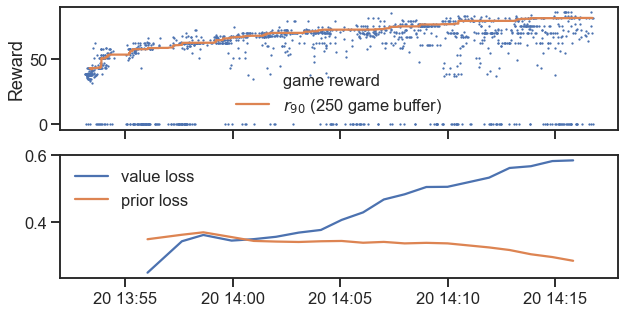

In [12]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')

In [ ]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

In [ ]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

In [ ]:
rew_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

TODO: 
* Maybe do ranked reward on an atom-by-atom basis?
* Also look into sulfur-containing radicals
* Some additional chemical feasibility constraints

In [ ]:
# rew_df.iloc[optimal[0]]